In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    build_features, 
    build_rolling_feature
)

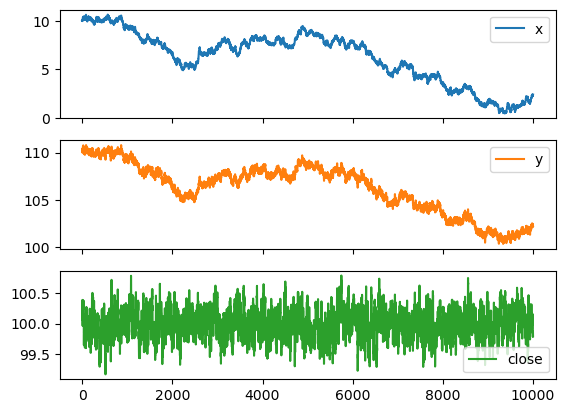

In [3]:
x, y = stationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [4]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.364e+06
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:59:33   Log-Likelihood:                 628.39
No. Observations:               10000   AIC:                            -1253.
Df Residuals:                    9998   BIC:                            -1238.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0138      0.006   1.73e+04      0.0

In [5]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -23.381178488803585
p-value: 0.0
Is the spread stationary? Yes


In [5]:
# build features
df_train = df.copy()

feature_config = {
    "feature_col": "close",
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff" # difference between current and previous close price
}

df_train = build_rolling_feature(df_train, **feature_config)
df_train

,x,y,close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,10.014957,109.917994,99.903037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.032802,109.948959,99.916157,0.013120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,9.984477,109.996115,100.011638,0.095482,0.013120,0.000000,0.000000,0.000000,0.000000,0.000000
3,9.992525,110.171509,100.178984,0.167346,0.095482,0.013120,0.000000,0.000000,0.000000,0.000000
4,9.901386,109.950998,100.049613,-0.129371,0.167346,0.095482,0.013120,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,11.266392,111.158967,99.892575,-0.090997,0.070868,0.040726,-0.096286,-0.019856,-0.057037,0.050036
9996,11.314226,111.012187,99.697961,-0.194614,-0.090997,0.070868,0.040726,-0.096286,-0.019856,-0.057037
9997,11.250709,111.041073,99.790364,0.092402,-0.194614,-0.090997,0.070868,0.040726,-0.096286,-0.019856
9998,11.179413,110.975398,99.795986,0.005622,0.092402,-0.194614,-0.090997,0.070868,0.040726,-0.096286


In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0. 1. 1.]
Market Return : -0.06%   |   Portfolio Return : -59.71%   |   Position Changes : 6693   |   Episode Length : 10000   |   


In [6]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -0.26%   |   Portfolio Return : -41.49%   |   Position Changes : 5639   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : -16.92%   |   Position Changes : 4910   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : -0.06%   |   Position Changes : 4687   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  1.84%   |   Position Changes : 4475   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  8.53%   |   Position Changes : 4523   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  1.62%   |   Position Changes : 4471   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return :  5.32%   |   Position Changes : 4282   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : 21.11%   |   Position Changes : 4310   |   Episode Length : 10000   |   
Market Return : -0.26%   |   P

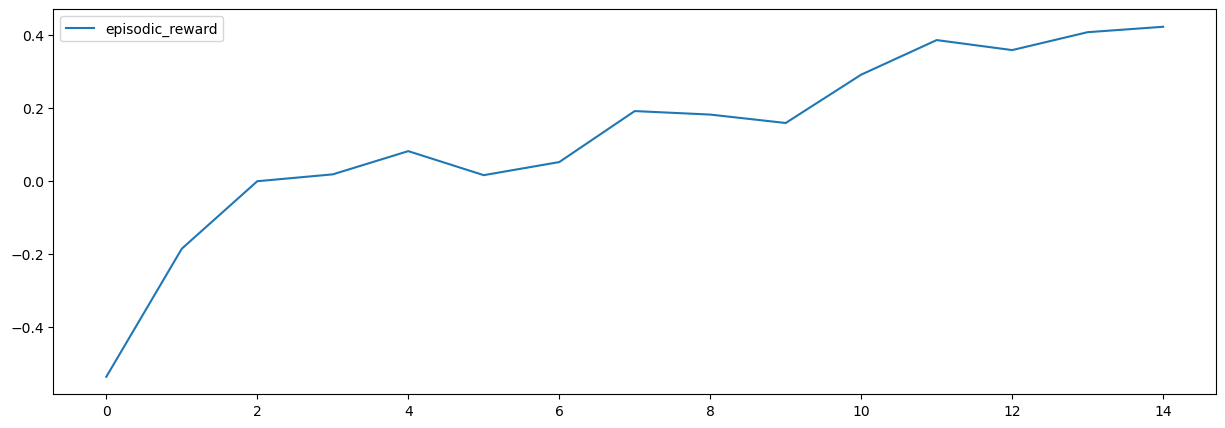

In [7]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [8]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    _df = build_rolling_feature(_df, **feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.34%   |   Portfolio Return : 50.14%   |   Position Changes : 2528   |   Episode Length : 10000   |   
Market Return :  0.19%   |   Portfolio Return : 32.73%   |   Position Changes : 2471   |   Episode Length : 10000   |   
Market Return :  0.48%   |   Portfolio Return : 35.57%   |   Position Changes : 2430   |   Episode Length : 10000   |   
Market Return : -0.30%   |   Portfolio Return : 43.88%   |   Position Changes : 2475   |   Episode Length : 10000   |   
Market Return :  0.31%   |   Portfolio Return : 50.57%   |   Position Changes : 2532   |   Episode Length : 10000   |   
Market Return : -0.15%   |   Portfolio Return : 57.82%   |   Position Changes : 2531   |   Episode Length : 10000   |   
Market Return :  0.28%   |   Portfolio Return : 54.06%   |   Position Changes : 2509   |   Episode Length : 10000   |   
Market Return : -0.26%   |   Portfolio Return : 51.19%   |   Position Changes : 2540   |   Episode Length : 10000   |   
Market Return : -0.07%   |   Por

In [9]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()

In [6]:
# build features
df_train = df.copy()

feature_config = {
    "feature_col": "close",
    "window": 1, # 7 days window, pad with first value when window is not available
    "mode": "diff" # difference between current and previous close price
}

df_train = build_rolling_feature(df_train, **feature_config)
df_train

,x,y,close,feature_rolling_0
0,9.991098,110.058331,100.067233,0.000000
1,9.985262,110.117779,100.132517,0.065284
2,9.994059,110.150702,100.156643,0.024127
3,10.011964,110.233821,100.221857,0.065214
4,9.958249,110.141896,100.183648,-0.038209
...,...,...,...,...
9995,2.296811,102.098266,99.801455,0.016825
9996,2.339786,102.154277,99.814491,0.013036
9997,2.395902,102.264156,99.868255,0.053764
9998,2.348978,102.155923,99.806945,-0.061309


In [7]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1. -1.]
Market Return : -0.27%   |   Portfolio Return :  0.27%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [14]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return : -0.27%   |   Portfolio Return : -58.11%   |   Position Changes : 6769   |   Episode Length : 10000   |   
Market Return : -0.27%   |   Portfolio Return : -65.08%   |   Position Changes : 6656   |   Episode Length : 10000   |   
Market Return : -0.27%   |   Portfolio Return : -46.35%   |   Position Changes : 5627   |   Episode Length : 10000   |   
Market Return : -0.27%   |   Portfolio Return : -43.49%   |   Position Changes : 5628   |   Episode Length : 10000   |   
Market Return : -0.27%   |   Portfolio Return : -24.74%   |   Position Changes : 4607   |   Episode Length : 10000   |   
Market Return : -0.27%   |   Portfolio Return : -27.29%   |   Position Changes : 4605   |   Episode Length : 10000   |   
Market Return : -0.27%   |   Portfolio Return : -12.17%   |   Position Changes : 2978   |   Episode Length : 10000   |   
Market Return : -0.27%   |   Portfolio Return : -5.90%   |   Position Changes : 3047   |   Episode Length : 10000   |   
Market Return : -0.27%   

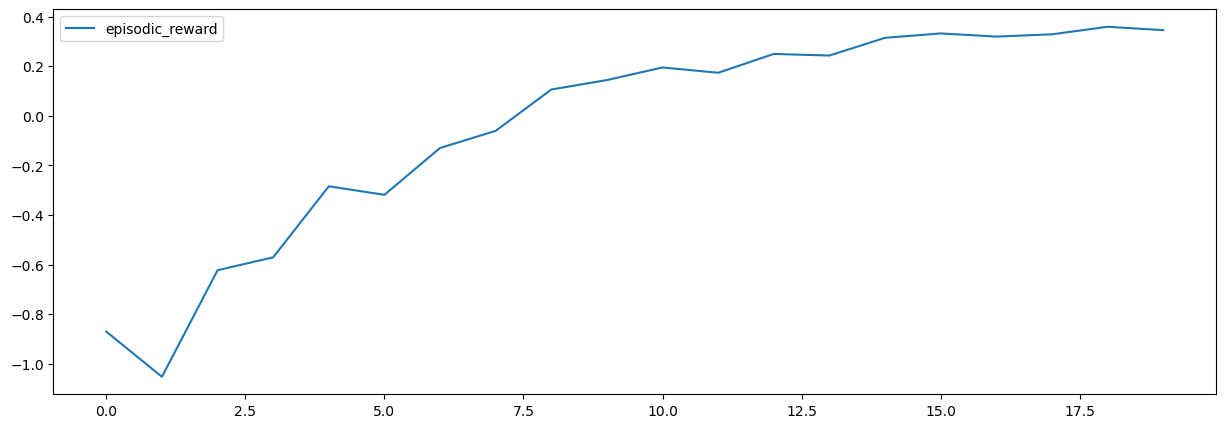

In [16]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [17]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    _df = build_rolling_feature(_df, **feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.02%   |   Portfolio Return : 23.40%   |   Position Changes : 1404   |   Episode Length : 10000   |   
Market Return :  0.30%   |   Portfolio Return : 15.49%   |   Position Changes : 1319   |   Episode Length : 10000   |   
Market Return : -0.13%   |   Portfolio Return : 25.24%   |   Position Changes : 1316   |   Episode Length : 10000   |   
Market Return : -0.05%   |   Portfolio Return : 24.41%   |   Position Changes : 1283   |   Episode Length : 10000   |   
Market Return :  0.38%   |   Portfolio Return : 24.61%   |   Position Changes : 1183   |   Episode Length : 10000   |   
Market Return : -0.16%   |   Portfolio Return : 17.58%   |   Position Changes : 1304   |   Episode Length : 10000   |   
Market Return :  0.36%   |   Portfolio Return : 21.90%   |   Position Changes : 1281   |   Episode Length : 10000   |   
Market Return :  0.04%   |   Portfolio Return : 24.99%   |   Position Changes : 1257   |   Episode Length : 10000   |   
Market Return : -0.00%   |   Por